In [1]:
from common import *

In [3]:
data = pd.read_csv('common/data/earthquake_data.csv')
R = 63710

lat_rad = np.radians(data['latitude'])
lon_rad = np.radians(data['longitude'])
r = R - data['depth']

data['x'] = r * np.cos(lat_rad) * np.cos(lon_rad)
data['y'] = r * np.cos(lat_rad) * np.sin(lon_rad)
data['z'] = r * np.sin(lat_rad)
X = data[['x','y','z']].values

In [4]:
import libpysal
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import rbf_kernel

# 1. Scaling
scaler = StandardScaler()
coords = data[['x', 'y', 'z']].values
mag_scaled = scaler.fit_transform(data[['mag']])

# 2. Build Spatial Connectivity (The "Constraint")
# Binary matrix: 1 if spatial neighbors, 0 if not
adj_binary = kneighbors_graph(coords, n_neighbors=11, mode='connectivity').toarray()

# 3. Build Attribute Similarity (Magnitude)
# High value if magnitudes are similar
mag_similarity = rbf_kernel(mag_scaled, gamma=1.0)

# 4. Create Weighted Adjacency Matrix
# This "masks" the magnitude similarity with the spatial graph
adj_weighted = adj_binary * mag_similarity

# Ensure symmetry (essential for Spectral Clustering)
adj_weighted = (adj_weighted + adj_weighted.T) / 2

# 5. Run Spectral Clustering
spectral = SpectralClustering(n_clusters = 3, 
                              affinity = 'precomputed', 
                              assign_labels = 'discretize', random_state=42)

data['spectral_cluster'] = spectral.fit_predict(adj_weighted)


In [6]:
print(data['spectral_cluster'].value_counts())

spectral_cluster
0    108
2     91
1     25
Name: count, dtype: int64


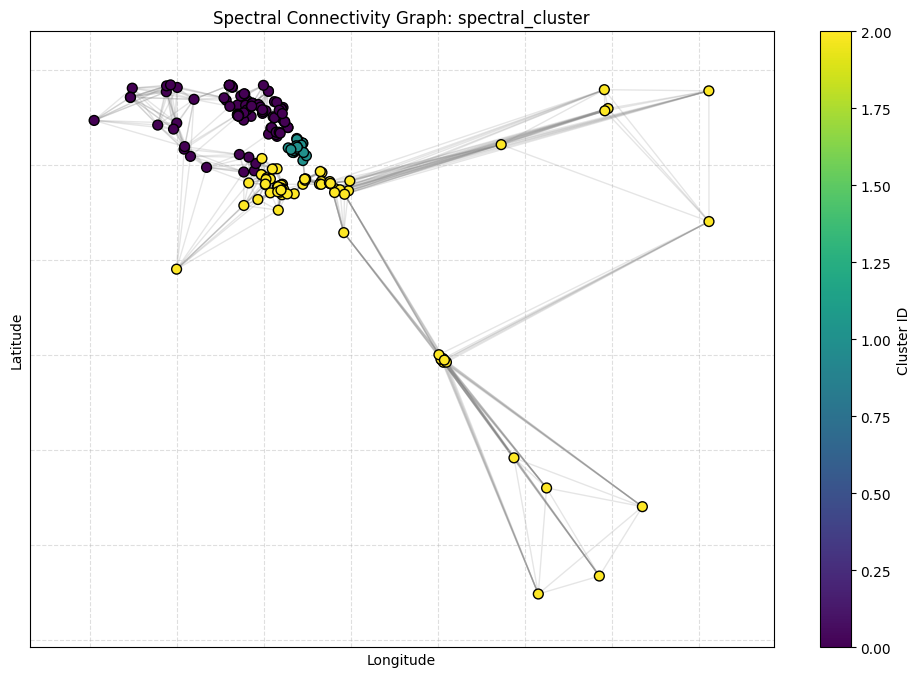

In [7]:
visualize_graph_connectivity(data, adj_binary, 'spectral_cluster')

In [11]:
visualize_3d(data, 'spectral_cluster')

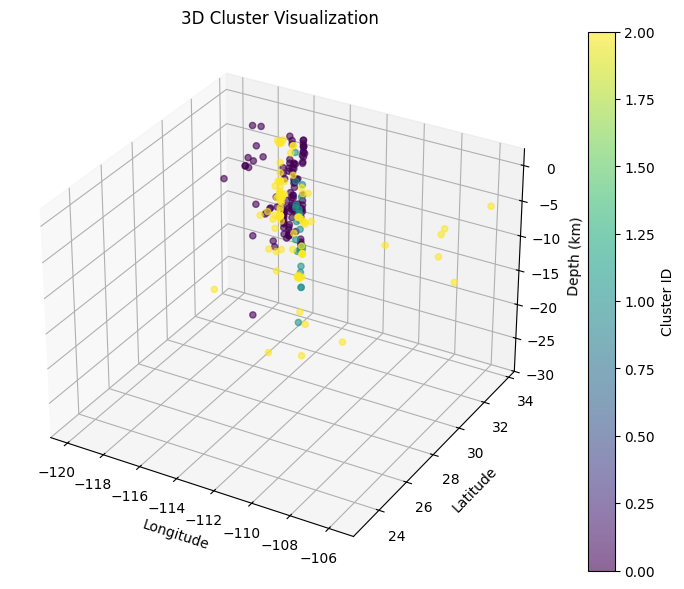

In [12]:
visualize_3d_static(data, 'spectral_cluster')

In [13]:
calculate_sillouette_score(adj_weighted, 'spectral_cluster', data)

Silhouette Score: 0.06364675049371316


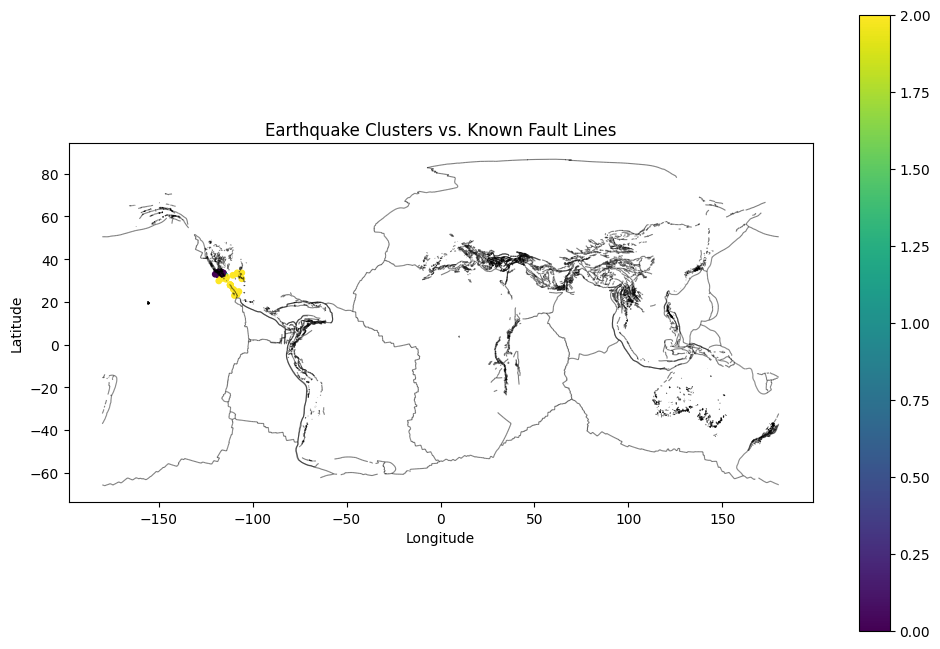

In [14]:
visualize_clusters_on_known_fault_lines(data, crs="EPSG:4326", cluster_column='spectral_cluster')